<a href="https://colab.research.google.com/github/ThakdanaiSaelee/Lab_CE888/blob/main/lab4%20-%20recommed/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Libraries for pre-processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [191]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header=None)
df.shape

(24983, 101)

In [192]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [193]:
# replace 99 by Nan because 99 mean 'not rate'
df = df.replace(99, np.nan)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [194]:
# Drop first column that in not a rating
df = df.drop(labels = 0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [207]:
# find the best and worst joke using mean value
mean_score = df.mean(axis = 0)
max = -10
max_joke = 0
min = 10
min_joke = 0
for i, v in enumerate(mean_score):
  if v > max:
    max = v
    max_joke = i + 1
  if v < min:
    min = v
    min_joke = i + 1
print('best joke is:',max_joke,'with score:',max,'and worst joke is:',min_joke,'with score',min)

best joke is: 50 with score: 3.6650848950824937 and worst joke is: 58 with score -3.8338796373689923


In [201]:
arr = df.values

In [200]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(~np.isnan(arr))                                                     # rated[0] = row, rated[1] = column
  n_rated = len(rated[0])                                                            # row
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = np.nan
  return new_data, (rated[0][idx], rated[1][idx])

In [202]:
# create validation set
validation_set , index = replace(arr,0.1)

In [203]:
n_latent_factors = 2

# Initialise as random values
latent_user_preferences = np.random.random((arr.shape[0], n_latent_factors))
latent_item_features = np.random.random((arr.shape[1], n_latent_factors))

In [211]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = arr[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/10:	MSE=20.657132
Iteration 1/10:	MSE=20.371173
Iteration 2/10:	MSE=20.063224
Iteration 3/10:	MSE=19.737773
Iteration 4/10:	MSE=19.404331
Iteration 5/10:	MSE=19.076206
Iteration 6/10:	MSE=18.767715
Iteration 7/10:	MSE=18.490743
Iteration 8/10:	MSE=18.252237
Iteration 9/10:	MSE=18.053652


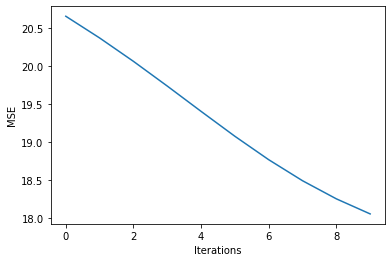

In [212]:
num_iter = 10
hist = sgd(num_iter)

plt.figure()
plt.plot(np.arange(0, num_iter,1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()